<h3>Libraries</h3>

In [312]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.optimize import minimize

<h3>Data</h3>

In [313]:
dataset = pd.read_excel("utils/Prueba.xlsx", index_col=0)
dataset.columns =[c.replace(" MF Equity","").replace(" INDEX","") for c in dataset.columns]
dataset = dataset.pct_change().dropna(axis=0)
dataset = dataset[['CEMEXCPO', 'WALMEX*', 'CUERVO*', 'BBAJIOO', 'IENOVA*', 'GMEXICOB', 'MEXBOL']]
dataset.head()

,CEMEXCPO,WALMEX*,CUERVO*,BBAJIOO,IENOVA*,GMEXICOB,MEXBOL
DATE,,,,,,,
2017-06-08,0.015489,-0.001183,-0.004255,0.021695,-0.000341,-0.005342,-0.003805
2017-06-09,0.025015,-0.000710,-0.006105,0.003981,0.001708,0.006167,-0.000117
2017-06-12,0.002381,-0.013033,0.012285,0.007931,0.004319,-0.013049,0.000958
2017-06-13,-0.006532,-0.012725,-0.008192,-0.003279,0.039040,-0.000200,-0.002075
2017-06-14,0.000000,0.025292,-0.002447,0.002961,0.028861,0.003005,0.005389


<h3>1- Rendimiento promedio constante diario y anual</h3>

In [314]:
print("*** Rendimiento diario\n\n{}\n".format(dataset.mean()))
print("*** Rendimiento anual\n\n{}".format(dataset.mean() * 252))

*** Rendimiento diario

CEMEXCPO   -0.001033
WALMEX*     0.000493
CUERVO*     0.000200
BBAJIOO     0.000249
IENOVA*     0.000153
GMEXICOB    0.000260
MEXBOL     -0.000111
dtype: float64

*** Rendimiento anual

CEMEXCPO   -0.260338
WALMEX*     0.124216
CUERVO*     0.050462
BBAJIOO     0.062645
IENOVA*     0.038623
GMEXICOB    0.065446
MEXBOL     -0.027950
dtype: float64


<h4>Rendimientos con CAPM</h4>

In [315]:
matriz_cov = dataset.cov()
betas =[]
rf=.05
pm = .10
rendis = []
rendis_a = []

for i in range(len(matriz_cov)-1):
    betas.append(matriz_cov.iloc[i, len(matriz_cov)-1] / matriz_cov.iloc[len(matriz_cov)-1, len(matriz_cov)-1])
    print("{} ({}) => {}".format(
        matriz_cov.columns[i], 
        ("agresiva" if betas[i]>1 else "defensiva"), 
        betas[i]))

print("")
for i in range(len(matriz_cov)-1):
    rendis.append((rf/252) + (betas[i] * (pm/252)))
    print("{} (CAPM - diario) => {}".format(matriz_cov.columns[i], rendis[i]))
    
print("")
for i in range(len(matriz_cov)-1):
    rendis_a.append(rendis[i] * 252)
    print("{} (CAPM - anual) => {}".format(matriz_cov.columns[i], rendis_a[i]))

CEMEXCPO (agresiva) => 1.2936222822706347
WALMEX* (defensiva) => 0.8843317460473239
CUERVO* (defensiva) => 0.3484213996681791
BBAJIOO (defensiva) => 0.8331184149617401
IENOVA* (defensiva) => 0.8716324608663579
GMEXICOB (agresiva) => 1.1575129218269742

CEMEXCPO (CAPM - diario) => 0.0007117548739169184
WALMEX* (CAPM - diario) => 0.0005493379944632238
CUERVO* (CAPM - diario) => 0.0003366751585984838
BBAJIOO (CAPM - diario) => 0.0005290152440324365
IENOVA* (CAPM - diario) => 0.0005442985955818881
GMEXICOB (CAPM - diario) => 0.000657743222947212

CEMEXCPO (CAPM - anual) => 0.17936222822706344
WALMEX* (CAPM - anual) => 0.1384331746047324
CUERVO* (CAPM - anual) => 0.08484213996681791
BBAJIOO (CAPM - anual) => 0.133311841496174
IENOVA* (CAPM - anual) => 0.1371632460866358
GMEXICOB (CAPM - anual) => 0.16575129218269744


<h3>2- Matriz de Varianza Covarianza</h3>

In [316]:
print("*** Matriz de varaizna convarianza\n\n{}\n".format(matriz_cov))

*** Matriz de varaizna convarianza

          CEMEXCPO   WALMEX*   CUERVO*   BBAJIOO   IENOVA*  GMEXICOB    MEXBOL
CEMEXCPO  0.000339  0.000046  0.000019  0.000070  0.000075  0.000102  0.000094
WALMEX*   0.000046  0.000219  0.000026  0.000047  0.000052  0.000053  0.000065
CUERVO*   0.000019  0.000026  0.000217  0.000031  0.000029  0.000011  0.000025
BBAJIOO   0.000070  0.000047  0.000031  0.000210  0.000061  0.000060  0.000061
IENOVA*   0.000075  0.000052  0.000029  0.000061  0.000261  0.000078  0.000064
GMEXICOB  0.000102  0.000053  0.000011  0.000060  0.000078  0.000318  0.000085
MEXBOL    0.000094  0.000065  0.000025  0.000061  0.000064  0.000085  0.000073



<h3>3- Frontera de carteras de mínima varianza y frontera eficiente</h3>

In [317]:
resumen = pd.DataFrame(zip(list(dataset.columns.values), rendis), columns=['Emisora', 'Rendimiento diario'])
rend_diario = resumen['Rendimiento diario']

def port_rend(weights, r):
    E_p = (rend_diario @ weights).sum() * 252
    return E_p

def port_vol(weights, r):
    S_p = np.sqrt(weights.T @ (r.cov() * 252) @ weights)
    return S_p

# Weights
weights_sim = np.random.random((5000, dataset.shape[1]-1))
weights_sim = weights_sim / weights_sim.sum(axis=1, keepdims=True)
rend_sim = np.apply_along_axis(port_rend, 1, weights_sim, r=dataset.iloc[:,:-1])
vol_sim = np.apply_along_axis(port_vol, 1, weights_sim, r=dataset.iloc[:,:-1])

print("dataset.iloc[:,:-1].shape => {}".format(dataset.iloc[:,:-1].shape))
print("rend_diario.shape         => {}".format(rend_diario.shape))
print("weights_sim.shape         => {}".format(weights_sim.shape))
print("")
print("rend_sim => {}".format(rend_sim))
print("vol_sim  => {}".format(vol_sim))

dataset.iloc[:,:-1].shape => (672, 6)
rend_diario.shape         => (6,)
weights_sim.shape         => (5000, 6)

rend_sim => [0.1418719  0.13600789 0.14644145 ... 0.14859355 0.13896794 0.1465887 ]
vol_sim  => [0.15579556 0.15910129 0.1694232  ... 0.17158819 0.14855409 0.1610473 ]


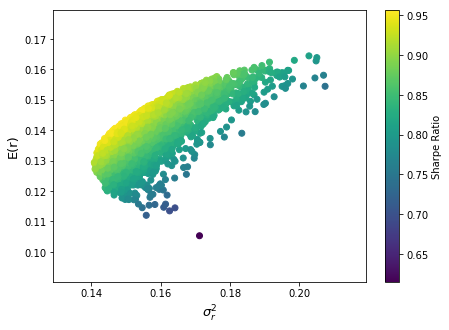

In [318]:
plt.figure(figsize=(7, 5))
plt.scatter(vol_sim, rend_sim, c=(rend_sim/vol_sim))
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13);

In [319]:
N, M = dataset.iloc[:,:-1].shape
w0  = np.random.randn(M)

def sum_weights(weights):
    return weights.sum() - 1 # == 0

def rend_esperado(w, E):
    return port_rend(w, rends) - E # == 0

port0 = minimize(port_vol, w0, constraints=[
    {"type": "eq", "fun": sum_weights}
], args=dataset.iloc[:,:-1])
port0

     fun: 0.14060155946541752
     jac: array([0.14068425, 0.14059058, 0.14045746, 0.14089207, 0.14030828,
       0.14075955])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.08810451, 0.21014473, 0.27956207, 0.1891969 , 0.12512762,
       0.10786416])

In [320]:
wp0 = port0.x
port_rend(wp0, dataset.iloc[:,:-1]), port_vol(wp0, dataset.iloc[:,:-1])

(0.12887599097871102, 0.14060155946541752)

TypeError: You must first set_array for mappable

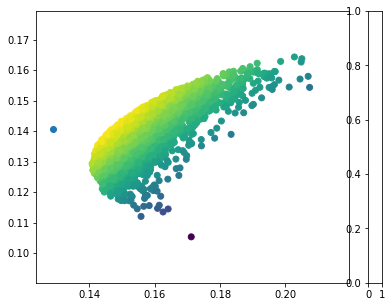

In [321]:
plt.figure(figsize=(7, 5))
plt.scatter(vol_sim, rend_sim, c=(rend_sim/vol_sim))
plt.scatter(port_rend(wp0, dataset.iloc[:,:-1]), port_vol(wp0, dataset.iloc[:,:-1]))
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13);

In [322]:
#defino los limites de la frontera
rmin = port_rend(wp0, dataset.iloc[:,:-1])
rmax = rend_sim.max()
rend_maxs = np.linspace(rmin, rmax)
rend_maxs

array([0.12887599, 0.12960053, 0.13032507, 0.13104961, 0.13177415,
       0.13249869, 0.13322323, 0.13394777, 0.13467231, 0.13539685,
       0.13612139, 0.13684593, 0.13757047, 0.13829501, 0.13901955,
       0.13974409, 0.14046863, 0.14119317, 0.14191771, 0.14264225,
       0.14336679, 0.14409133, 0.14481587, 0.14554041, 0.14626495,
       0.14698949, 0.14771403, 0.14843857, 0.14916312, 0.14988766,
       0.1506122 , 0.15133674, 0.15206128, 0.15278582, 0.15351036,
       0.1542349 , 0.15495944, 0.15568398, 0.15640852, 0.15713306,
       0.1578576 , 0.15858214, 0.15930668, 0.16003122, 0.16075576,
       0.1614803 , 0.16220484, 0.16292938, 0.16365392, 0.16437846])

In [323]:
pesos_optimos = []
N, M = dataset.iloc[:,:-1].shape
w_opt = np.random.randn(M)

for e in rend_maxs:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w_opt: rend_esperado(w_opt, e)},
    ]
    port_opt = minimize(port_vol, w_opt,  constraints = constraints, args=dataset.iloc[:,:-1])
    w_opt = port_opt.x
    pesos_optimos.append(w_opt)
    
print("Pesos optimos => {}".format(w_opt))
print("Sume pesos op => {}".format(w_opt.sum()))

Pesos optimos => [ 0.33996181  0.25560609 -0.11256527  0.15255355  0.11110106  0.25334275]
Sume pesos op => 1.0


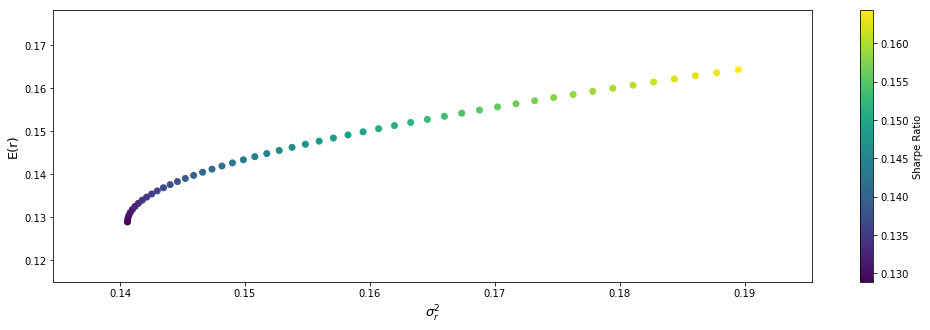

In [324]:
r_opt = []
v_opt = []

for w in pesos_optimos:
    r_opt.append(port_rend(w, dataset.iloc[:,:-1]))
    v_opt.append(port_vol(w, dataset.iloc[:,:-1]))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.figure(figsize=(17, 5))
plt.scatter(v_opt, r_opt, c=r_opt)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

<h3>4- Portafolio riesgoso óptimo (maximiza el coeficiente de Sharpe)</h3>

Pesos optimos => [0.22708425 0.2368604  0.06221427 0.16868495 0.11779027 0.18736585]
Sume pesos op => 1.0


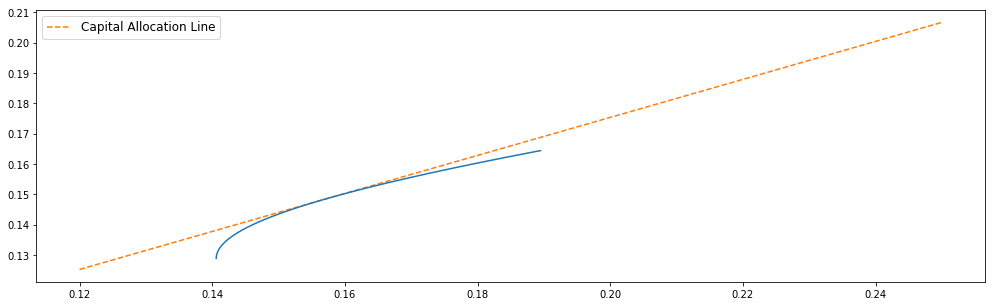

In [333]:
A=3

def min_func_sharpe(weights):
    return - (port_rend(weights, dataset.iloc[:,:-1]) - rf) / port_vol(weights, dataset.iloc[:,:-1])

constraints_sharpe = [
    {"type": "eq", "fun": sum_weights}
]

f_sharpe = minimize(min_func_sharpe, w0, constraints=constraints_sharpe)
w_sharpe = f_sharpe.x
print("Pesos optimos => {}".format(w_sharpe))
print("Sume pesos op => {}".format(w_sharpe.sum()))

e_sharpe = port_rend(w_sharpe, dataset.iloc[:,:-1])
vol_sharpe = port_vol(w_sharpe, dataset.iloc[:,:-1])
sigma_c =  np.linspace(.12, 0.25)
sharpe = (rf) + sigma_c * (e_sharpe - (rf)) / vol_sharpe
plt.figure(figsize=(17, 5))
plt.plot(sigma_c, sharpe, linestyle="--", c="tab:orange", label="Capital Allocation Line")
plt.plot(v_opt, r_opt)
plt.legend(fontsize=12);

<h3>5- Elige los porcentajes a invertir en el portafolio riesgoso óptimo y el activo libre de riesgo</h3>

In [342]:
y_star = (e_sharpe-rf) / (A*vol_sharpe**1)

print("Riesgo optimo   => {}".format(y_star))
print("Libre de riesgo => {}\n".format(1-y_star))
print("E[u] = {}".format(rf+y_star*(e_sharpe-rf)))
print("V[u] = {}".format(y_star*vol_sharpe))

Riesgo optimo   => 0.20888972943863024
Libre de riesgo => 0.7911102705613697

E[u] = 0.07057530330206149
V[u] = 0.03283279868498961


<h3>6- ¿En qué escenarios ocuparías una red neuronal?</h3>
<p>En clasifiacion, forecasting y tareas complejas, ya que se puede aplicar transformaciones a los datos.</p>

<h3>7-¿En qué escenarios no ocuparías una red neuronal?</h3>
<p>Cuando se tiene un dataset muy pequeño o si no se cuenta con los recursos computacionales necesarios que pueden ejecutar las tareas tan complejas del modelo.</p>

<h3>8- Menciona tres funciones de activación para una red neuronal feed-forward</h3>
<ul>
    <li>ReLu</li>
    <li>Sigmoidal</li>
    <li>Tangencial</li>
</ul>

<h3>9- ¿Qué es el método de backpropagation?</h3>
<p>El output que se predijo es comparado con el output conocido y si no hace match, se deberá ajsutar el peso.</p>

<h3>10- ¿En qué difiere una red neuronal feed-forward de una red neuronal convolucional?</h3>
<p>Las capas ocultas de CNN (convolutional neural network) generalmente consisten en una serie de capas convolucionales que se relacionan con una multiplicación o producto de puntos. Feedforward neural network es una red que no es recursiva. Las neuronas de esta última capa sólo están conectadas a las neuronas de la siguiente capa.</p>